In [1]:
import tensorflow
import keras 

Using TensorFlow backend.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [7]:
train_df = pd.read_csv('dataset/train.csv',parse_dates=['date'],index_col='date')
test_df = pd.read_csv("dataset/test.csv",parse_dates=['date'],index_col='date')

In [8]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


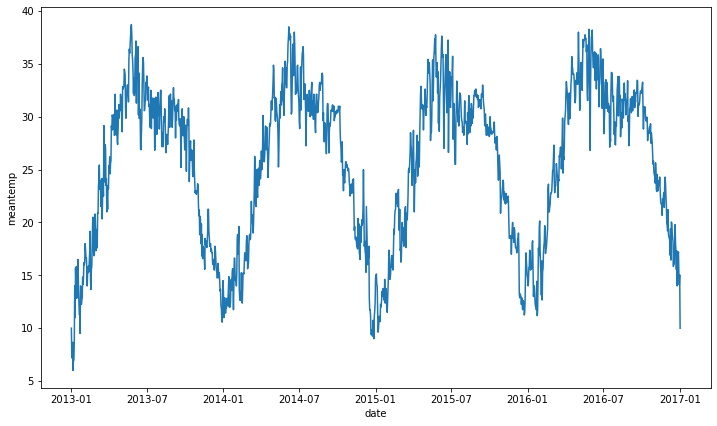

In [10]:
plt.figure(figsize=(12,7))
sns.lineplot(train_df.index,train_df['meantemp'],data=train_df)

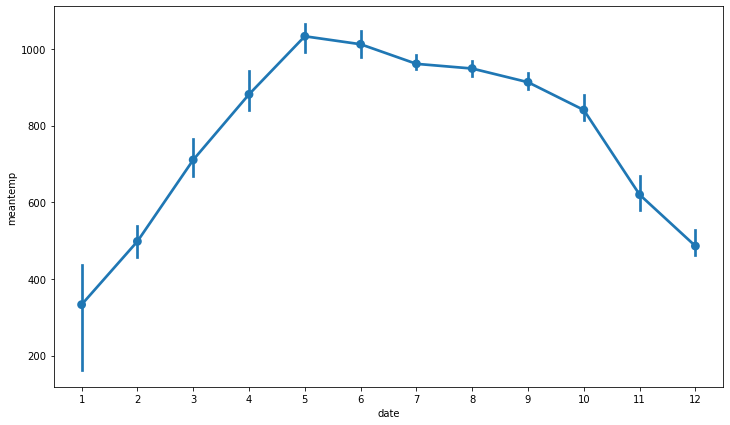

In [13]:
train_by_month = train_df.resample("M").sum()

plt.figure(figsize=(12,7))
sns.pointplot(train_by_month.index.month,train_by_month['meantemp'],data=train_by_month)

In [14]:
from sklearn.preprocessing import RobustScaler

In [18]:
rc_det = RobustScaler()
rc_temp = RobustScaler()

trans_col = ['humidity','wind_speed','meanpressure']

train_df.loc[:,trans_col] = rc_det.fit_transform(train_df[trans_col].to_numpy())
test_df.loc[:,trans_col] = rc_det.transform(test_df[trans_col].to_numpy())

train_df['meantemp'] = rc_temp.fit_transform(train_df[['meantemp']])
test_df['meantemp'] = rc_temp.transform(test_df[['meantemp']])

In [23]:
def create_dataset(x,y,time_steps=1):
    x_train,y_train = [],[]
    
    for i in tqdm(range(len(x)-time_steps)):
        v = x.drop('meantemp',axis=1).iloc[i:i+time_steps].values
        x_train.append(v)
        y_train.append(x['meantemp'].iloc[i+time_steps])
        
    return np.array(x_train),np.array(y_train)

In [24]:
time_steps = 20

x_train,y_train = create_dataset(train_df,train_df.meantemp,time_steps)
x_test,y_test = create_dataset(test_df,test_df.meantemp,time_steps)

print(x_train.shape,y_train.shape)

C:\Users\danis\Anaconda3\envs\Ai2\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



(1442, 20, 3) (1442,)


In [41]:
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dropout,Dense
from keras.callbacks import EarlyStopping,ModelCheckpoint
from livelossplot import PlotLossesKeras

In [42]:
def create_model():
    
    model = Sequential()
    
    model.add(Bidirectional(LSTM(8,
                                input_shape=(x_train[1],x_train[2]))))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam',loss='mse')
    
    return model

model = create_model()
#model.summary()

In [43]:
callback = [ModelCheckpoint('tmp_weights/epochs__{epoch:02d}',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss'),
           EarlyStopping(patience=15,
                        monitor='val_loss'),
           PlotLossesKeras()]

In [44]:
h = model.fit(x_train,y_train,
         validation_split=0.1,
         epochs=40,
         batch_size=16,
         shuffle=False)

Train on 1297 samples, validate on 145 samples
Epoch 1/40
1297/1297 [==============================] - 2s 1ms/step - loss: 0.1788 - val_loss: 0.1125
Epoch 2/40
1297/1297 [==============================] - 1s 785us/step - loss: 0.0815 - val_loss: 0.0858
Epoch 3/40
1297/1297 [==============================] - 1s 771us/step - loss: 0.0806 - val_loss: 0.0796
Epoch 4/40
1297/1297 [==============================] - 1s 824us/step - loss: 0.0749 - val_loss: 0.0801
Epoch 5/40
1297/1297 [==============================] - 1s 966us/step - loss: 0.0698 - val_loss: 0.0797
Epoch 6/40
1297/1297 [==============================] - 1s 842us/step - loss: 0.0667 - val_loss: 0.0781
Epoch 7/40
1297/1297 [==============================] - 1s 856us/step - loss: 0.0647 - val_loss: 0.0780
Epoch 8/40
1297/1297 [==============================] - 1s 895us/step - loss: 0.0606 - val_loss: 0.0799
Epoch 9/40
1297/1297 [==============================] - 1s 860us/step - loss: 0.0619 - val_loss: 0.0807
Epoch 10/40
1297/12

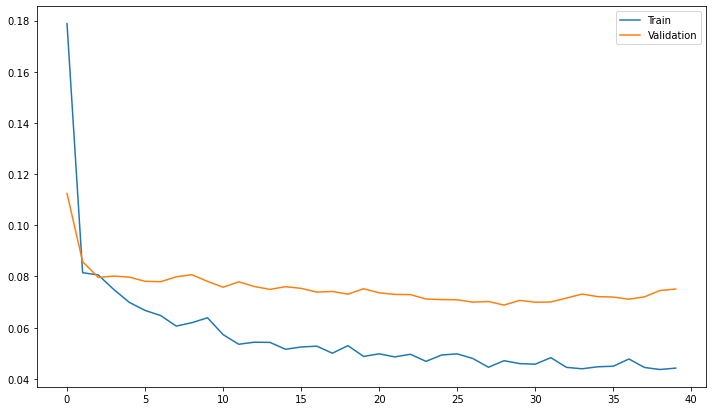

In [45]:
plt.figure(figsize=(12,7))
plt.plot(h.history['loss'],label='Train')
plt.plot(h.history['val_loss'],label='Validation')
plt.legend()

In [46]:
y_pred = model.predict(x_test)

In [47]:
y_pred_inv = rc_temp.inverse_transform(y_pred)
y_test = rc_temp.inverse_transform(y_test.reshape(-1,1))

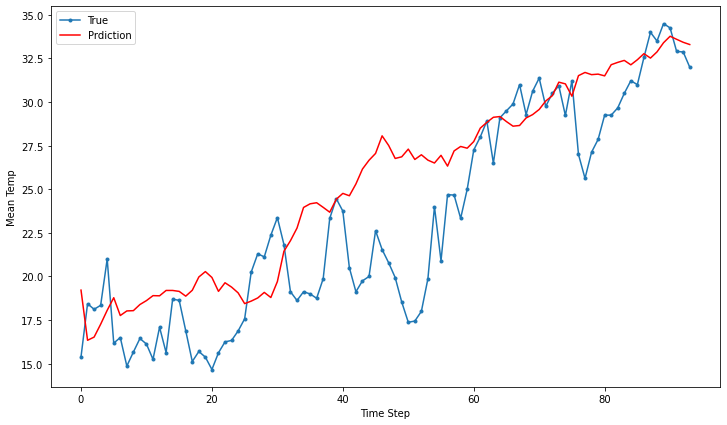

In [51]:
plt.figure(figsize=(12,7))
plt.plot(y_test.flatten(),label='True',marker='.')
plt.plot(y_pred_inv.flatten(),'r',label="Prdiction")
plt.xlabel('Time Step')
plt.ylabel("Mean Temp")
plt.legend()

In [53]:
model.save('Final Model')

In [55]:
model_json = model.to_json()

with open("model.json",'w') as file:
    file.write(model_json)